# Module 13 - Programming Assignment

## k Nearest Neighbors and Model Evaluation

You must complete the 4 following tasks:

1. Implement k-Nearest Neighbor *regression* as described in the Module.
2. Use validation curves as described in Module 9 to determine the best value of k trying values of 1 to 10. (You don't need to use odd values for regression). For this you can simply split the data randomly into a training and a test set with a 67/33 split.
3. Use learning curves as described in Module 9 to determine if your model could use more data.
    For this you can simply split the data randomly into a training and a test set with a 67/33 split. Use the best k from part 2.
4. Use 10-fold cross-validation to establish confidence bounds on your model's performance. Calculate the mean (average) MSE (which sounds funny, I know) and the standard deviation. 

Additionally, because you can't be *wrong* with the k = 1 in the training data, your curves will look a little funky initially.

As before make sure you actually plot curves and that everything is labeled. Each chart from part #2 and #3 has *two* curves. Please review the comments to Module 9 if you're not sure why.

Use the data in concrete_compressive_strength.csv for this assignment obtainable at [UCI ML Repository - Concrete Compressive Strength](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength).

Because the data is always the model, for knn, you simply need a function `knn` that will take the data, a value for k, and a List of instances and return a List of predictions (in this case, we're doing regression...you don't have to write a version of `knn` that would do either).

As before there's a lot of infrastructure involved and the specific names I leave up to you as long as you clearly indicate your answers to 1-4 above.

-----

In [1]:
import csv
import math
import random
import matplotlib.pyplot as plt

&nbsp;

## Helper Functions

&nbsp;

**Read CSV**

This function takes a file in CSV format and reads it into a list of lists.  Specifically, each inner list is a list that represents one row in the CSV file, also known as as an instance.  Each instance is read in as a list of floats.  The data is used in this format throughout the implementation of k nearest neighbor.  For the rest of the program, this structure will be referred to as the data.

In [2]:
def read_csv(file_name):
    with open(file_name, 'rb') as f:
        reader = csv.reader(f)
        next(reader, None)
        table = [[float(x) for x in record] for record in reader]
    
    return table[1:len(table)]

&nbsp;

**Euclidean Distance**

Given a row from the data and an instance, this function calulates the Euclidean distance between the two data points, ignoring the square root portion of Euclidean distance.  The square root is not used, because this distance is solely being used to compare with other distances, and the extra square root operation will not change the ordering of the comparisons.

In [3]:
#Euclidean distance without sqrt
def euclidean_distance(row, instance):
    distance = 0.0
    for i in range(len(row) - 2):       #skip the y
        distance += (row[i] - instance[i]) ** 2.0
        
    return distance

&nbsp;

**Priority Queue Insert**

A priority queue is used to keep track of the distances between a given instance and each of the data points in the data.  The queue is a list of tuples of format (distance, y-value of data point).  The priority queue is ordered by increasing distance.  The first k items in the priority queue represent the k nearest neighbors to the given instance.  This function inserts a tuple into the priority queue in its correct location based on its distance value. 

In [4]:
def priority_queue_insert(priority_queue, value):
    added = False
    for i in range(len(priority_queue)):
        entry = priority_queue[i]
        if value[0] < entry[0]:
            priority_queue.insert(i, value)
            added = True
            break
        if value[0] == entry[0]:
            priority_queue.insert(i + 1, value)
            added = True
            break
                
    if not added:
        priority_queue.append(value)

&nbsp;

**Average Ys**

Given the k nearest neighbors, in the format described above, this function takes the average of all of the y values of the k nearest neighbors.  This is necessary to predict a value for a given instance.

In [5]:
def average_ys(k_nearest_neighbors):
    sum = 0.0
    for neighbor in k_nearest_neighbors:
        sum += neighbor[-1]
    
    return sum / len(k_nearest_neighbors)

&nbsp;

**Predict Instance**

Given the data, a k value, and an instance, this function predicts a value for that instance.  It initializes a list to represent the distance priority queue, iterates through each data point and calculates the euclidean distance from the data point to the instance, and inserts the (distance, y-value) tuple into the distance priority queue.  After iterating through all the data points, it makes a prediction by averaging the y values of the first k entries in the distance priority queue (the k nearest neighbors).  It returns the prediction.

In [6]:
def predict_instance(data, k, instance):
    distance_priority_queue = []
    for row in data:
        distance = euclidean_distance(row, instance)
        insert_value = (distance, row[-1])
        priority_queue_insert(distance_priority_queue, insert_value)
         
    prediction = average_ys(distance_priority_queue[:k])
    return prediction

&nbsp;

**Create Train and Test Sets**

Given the data, this function creates a test set and a training set.  It randomizes the data, then splits the data with a 67/33 split where 67% is the training set and 33% is the test set.  Both sets are returned. This function is used to generate both learning and validation curves.

In [8]:
def create_train_test_sets(data):
    random.shuffle(data)
    split_point = len(data) / 3
    test_set = data[:split_point]
    train_set = data[split_point:]
    
    return train_set, test_set

&nbsp;

**x**

x

In [9]:
def plot_validation_curve(k_values, test_error_values, train_error_values):
    plt.plot(k_values, test_error_values, label='test data')
    plt.plot(k_values, train_error_values, label='train data') 
    plt.legend(loc='upper right')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('K Nearest Neighbors')
    plt.show()

&nbsp;

**x**

x

In [11]:
'''
3. Use learning curves as described in Module 9 to determine if your model could use more 
    data. For this you can simply split the data randomly into a training and a test set 
    with a 67/33 split. Use the best k from part 2.
'''

def plot_learning_curves(training_set_sizes, test_error_values, train_error_values):
    plt.plot(training_set_sizes, test_error_values, label='test data')
    plt.plot(training_set_sizes, train_error_values, label='train data') 
    plt.legend(loc='upper right')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Training Set Size (fraction of whole training set)')
    plt.show()

&nbsp;

**x**

x

In [13]:
'''
4. Use 10-fold cross-validation to establish confidence bounds on your model's 
    performance. Calculate the mean (average) MSE (which sounds funny, I know) and the 
    standard deviation.
'''
def create_folds(data, num_folds):
    folds = []
    random.shuffle(data)
    
    fold_index = 0
    for i in range(0, len(data) - 1, num_folds):
        if fold_index < num_folds:
            folds.append(data[i:i + num_folds])
            fold_index += 1
        
    return folds

&nbsp;

**x**

x

In [14]:
def calculate_mean_squared_error(actuals, predictions):
    mse = 0.0
    num_observations = len(actuals)
    for i in range(num_observations):
        actual = actuals[i]
        prediction = predictions[i]
        mse += (actual - prediction) ** 2.0
    
    mse = mse / num_observations
    return mse

&nbsp;

**x**

x

In [15]:
def calculate_standard_deviation(mean, values):
    standard_deviation = 0.0
    for value in values:
        standard_deviation += (value - mean) ** 2
    
    standard_deviation /= len(values)
    standard_deviation = math.sqrt(standard_deviation)
    return standard_deviation

&nbsp;

## K Nearest Neighbor Regression

x

In [7]:
#return a list of predictions (regression)
def k_nearest_neighbors(data, k, instances):
    predictions = []
    for instance in instances:
        predictions.append(predict_instance(data, k, instance))
        
    return predictions

&nbsp;

## Generate Validation Curves

x

In [10]:
def generate_validation_curves(data):
    train_set, test_set = create_train_test_sets(data)
    train_error_values = []
    test_error_values = []
    k_values = [k for k in range(1, 11)]
    best_k = k_values[0]
    lowest_error = float('inf')
    
    for k in k_values:
        test_predictions = k_nearest_neighbors(train_set, k, test_set)             
        train_predictions = k_nearest_neighbors(train_set, k, train_set)  
        
        test_actuals = [x[-1] for x in test_set]
        train_actuals = [x[-1] for x in train_set]
        
        test_mse = calculate_mean_squared_error(test_actuals, test_predictions)
        train_mse = calculate_mean_squared_error(train_actuals, train_predictions)
        
        average_error = (test_mse + train_mse) / 2.0
        if average_error < lowest_error:
            lowest_error = average_error
            best_k = k

        test_error_values.append(test_mse)
        train_error_values.append(train_mse)
    
    plot_validation_curve(k_values, test_error_values, train_error_values)
    return best_k

&nbsp;

## Generate Learning Curves

x

In [12]:
def generate_learning_curves(data, k):
    training_set_sizes = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1]
    train_set, test_set = create_train_test_sets(data)
    train_error_values = []
    test_error_values = []
    
    
    for percentage in training_set_sizes:
        train_set_size = int(percentage * len(train_set))
        train_set_partition = train_set[:train_set_size]
                
        test_predictions = k_nearest_neighbors(train_set_partition, k, test_set)             
        train_predictions = k_nearest_neighbors(train_set_partition, k, train_set_partition)  
        
        test_actuals = [x[-1] for x in test_set]
        train_actuals = [x[-1] for x in train_set_partition]
        
        test_mse = calculate_mean_squared_error(test_actuals, test_predictions)
        train_mse = calculate_mean_squared_error(train_actuals, train_predictions)

        test_error_values.append(test_mse)
        train_error_values.append(train_mse)
     
    plot_learning_curves(training_set_sizes, test_error_values, train_error_values)   

&nbsp;

## 10-Fold Cross Validation

x

In [16]:
def cross_validation(data, k):
    average_mse = 0.0
    mse_values = []
    num_folds = 10
    folds = create_folds(data, num_folds)
    
    for i in range(len(folds)):
        instances = folds[i]                         #chunk of instances
        train = []                              #bigger chunk of instances
        for fold in folds[:i]:
            for instance in fold:
                train.append(instance)
        for fold in folds[i + 1:]:
            for instance in fold:
                train.append(instance)
        
        predictions = k_nearest_neighbors(train, k, instances)        
        actuals = [x[-1] for x in instances]
        mse = calculate_mean_squared_error(actuals, predictions)
        
        average_mse += mse
        mse_values.append(mse)
    
    average_mse = average_mse / num_folds
    standard_deviation = calculate_standard_deviation(average_mse, mse_values)

    return average_mse, standard_deviation

---

## Test K Nearest Neighbor

**Generate Validation Curves**

In [17]:
data = read_csv('concrete-data.csv')

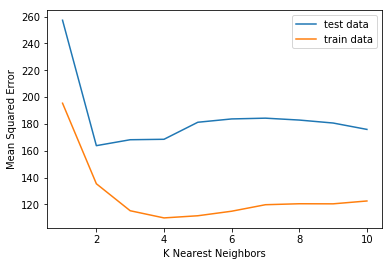

Best K:  4


In [18]:
best_k = generate_validation_curves(data)
print 'Best K: ', best_k

**Generate Learning Curves**

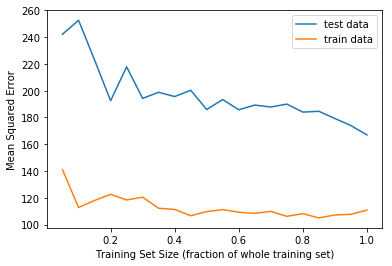

In [19]:
generate_learning_curves(data, best_k)

**Perform 10-Fold Cross Validation**

In [20]:
average_mse, standard_deviation = cross_validation(data, 10)
print "Average MSE: ", average_mse
print "Standard Deviation: ", standard_deviation

Average MSE:  162.61280672
Standard Deviation:  59.5137254813
